# Corporación Favorita Grocery Sales Forecasting

Authors: shiying Chen, Jianjun Du,  Bo Huang, Yanyan Zhu, 

Features: big data, 120 million records; time series; regressions; clusering

Part I: data preprocess, descriptive data analysis, feature engineering

part II: time series analysis

Part III: model selection, tuning, and evaluation

## part I: data preprocess, descriptive data analysis, feature engineer

### 1.1 data input and preprocess

In [2]:
#  Corporación Favorita Grocery Sales Forecasting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [13]:
# read in data, and made some modification to make them smaller
# reference: https://www.kaggle.com/heyt0ny/read-data-for-low-memory-usage
def loaddata(filename):
    types = {'id': 'int64',
             'item_nbr': 'int32',
             'store_nbr': 'int16',
             'unit_sales': 'float32',
             'onpromotion': bool,
    }
    data = pd.read_csv(filename, dtype=types)
    data['onpromotion'].fillna(False, inplace = True)
    data['onpromotion'] = data['onpromotion'].map({False : 0, True : 1})
    data['onpromotion'] = data['onpromotion'].astype('int8')
    return data

train=loaddata("train.csv")

In [14]:
# detach the date column to year (2013, 2014,..), day of the week(monday,tuesday,..), month(january, February, et..)
DateIndex=pd.DatetimeIndex(train['date'])
train['year']=DateIndex.year
train['month']=DateIndex.month
train['dayofweek']=DateIndex.weekday

In [15]:
stores=pd.read_csv("stores.csv")
holidays=pd.read_csv("holidays_events.csv")
items=pd.read_csv("items.csv")
oilprice=pd.read_csv("oil.csv")
transactions=pd.read_csv("transactions.csv")

### 1.2 descriptive data analysis

In [16]:
# How many items are sold by the company?
train.item_nbr.nunique()


4036

In [17]:
# How many stores owned by the company?
train.store_nbr.nunique()

54

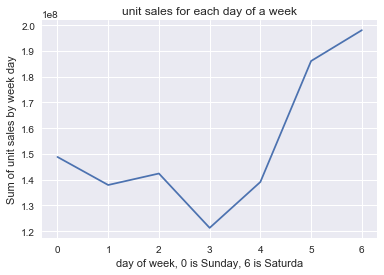

In [18]:
# Is there any difference for each day of week?
grouped=train[['dayofweek','unit_sales']].groupby('dayofweek')
sales=grouped.sum()
plt.plot(sales)
plt.title("unit sales for each day of a week")
plt.xlabel("day of week, 0 is Sunday, 6 is Saturda")
plt.ylabel("Sum of unit sales by week day")
plt.show()

# The figure shows that Friday and Saturday have the biggest sales, and Wednesday has the smmallest sales

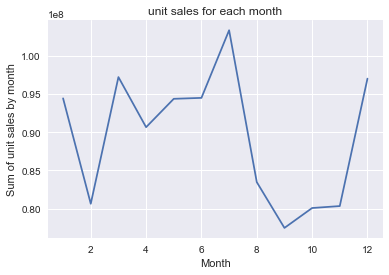

In [19]:
# Is there any difference for each month?
grouped=train[['month','unit_sales']].groupby('month')
sales=grouped.sum()
plt.plot(sales)
plt.title("unit sales for each month")
plt.xlabel("Month")
plt.ylabel("Sum of unit sales by month")
plt.show()

# July has the biggest sale

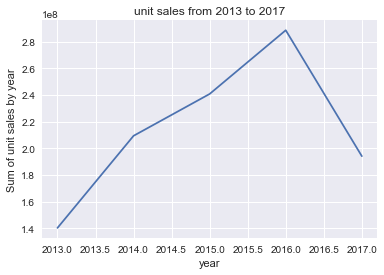

In [20]:
# Is there any difference for each year?
grouped=train[['year','unit_sales']].groupby('year')
sales=grouped.sum()
plt.plot(sales)
plt.title("unit sales from 2013 to 2017")
plt.xlabel("year")
plt.ylabel("Sum of unit sales by year")
plt.show()

# The sales is decreasing from 2016 to 2017, that is because the data only cover part of 2017.

In [21]:
# What are the sales per stores?
# What are the locations of the top 10 stores
grouped=train[['store_nbr','unit_sales']].groupby('store_nbr')
sales=grouped.sum().sort_values('unit_sales',ascending=False)
sales['store_nbr']=sales.index
pd.merge(sales,stores,on='store_nbr').head(10)

# Quito, Pichincha is the major market for the company

,unit_sales,store_nbr,city,state,type,cluster
0,62087544.0,44,Quito,Pichincha,A,5
1,54498012.0,45,Quito,Pichincha,A,11
2,50948308.0,47,Quito,Pichincha,A,14
3,50481900.0,3,Quito,Pichincha,D,8
4,43420088.0,49,Quito,Pichincha,A,11
5,41896052.0,46,Quito,Pichincha,A,14
6,35933132.0,48,Quito,Pichincha,A,14
7,32911484.0,51,Guayaquil,Guayas,A,17
8,30491336.0,8,Quito,Pichincha,D,8
9,28653018.0,50,Ambato,Tungurahua,A,14


In [30]:
mydata=train[['store_nbr','unit_sales','month']]
sales=pd.merge(mydata,stores,on='store_nbr')

In [38]:
grouped=sales.groupby(['type','month'])
sales_month=grouped.sum().reset_index()

In [39]:
sales_month.head()

,type,month,store_nbr,unit_sales,cluster
0,A,1,109377928.0,31675258.0,28542884
1,A,2,99446472.0,26034388.0,25963957
2,A,3,114596929.0,31847554.0,29911543
3,A,4,108043475.0,29366030.0,28128572
4,A,5,115959751.0,30860614.0,30076820


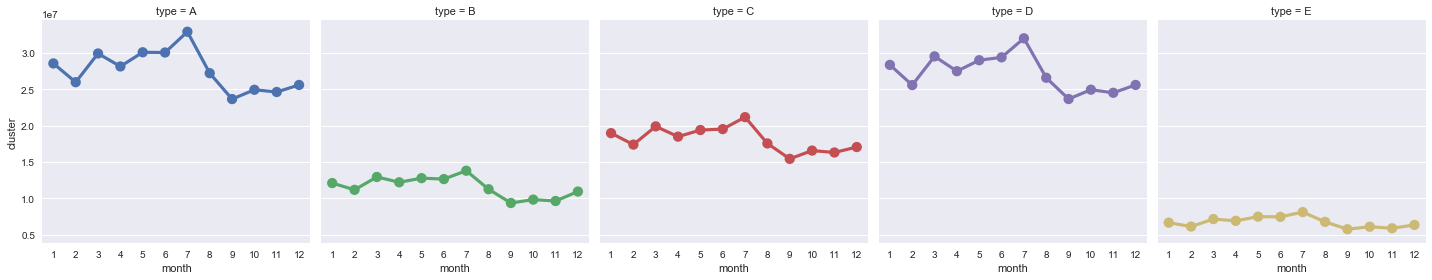

In [48]:
sns.factorplot(data = sales_month, x = 'month', y = "cluster", 
               col='type',
               hue = 'type',
               orient='v')

# The plot shows that type A and D are similar. ALl the types have similar sales pattern on month

In [11]:
# What are the top sold items?
grouped=train[['item_nbr','unit_sales']].groupby('item_nbr')
sales=grouped.sum().sort_values('unit_sales',ascending=False)
sales['item_nbr']=sales.index
sales.head(10)

,unit_sales,item_nbr
item_nbr,,
1503844,6264200.0,1503844
1047679,5512875.0,1047679
1473474,4990322.5,1473474
364606,4416426.0,364606
819932,4410943.0,819932
1463992,4408545.0,1463992
807493,4321424.0,807493
265559,4112827.0,265559
502331,3703350.0,502331


In [ ]:
for i in range(55):
    data=train[train.store_nbr==i]
    path="store_"+str(i)+".csv"
    data.to_csv(path)

## Part II: time series analysis

Time series data has some unique characteristics, such as trends, seasonalities. We will do a typical time series analysis first, and then develop a prediction model with prophet, which was open sourced by facebook.

In [8]:
from fbprophet import Prophet
import seaborn as sns
%matplotlib inline

In [11]:
df=pd.read_csv("store_1.csv")
df=df[['date','unit_sales','item_nbr']]
df=df[df['item_nbr']==103665]
df['ds']=df['date']
df['y']=df['unit_sales']
m=Prophet(daily_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1718,2018-08-11
1719,2018-08-12
1720,2018-08-13
1721,2018-08-14
1722,2018-08-15


In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1718,2018-08-11,3.509818,0.678512,6.341233
1719,2018-08-12,1.602063,-1.315008,4.488555
1720,2018-08-13,2.225024,-0.599171,5.095187
1721,2018-08-14,2.767001,-0.220148,5.600485
1722,2018-08-15,2.553142,-0.382057,5.596542


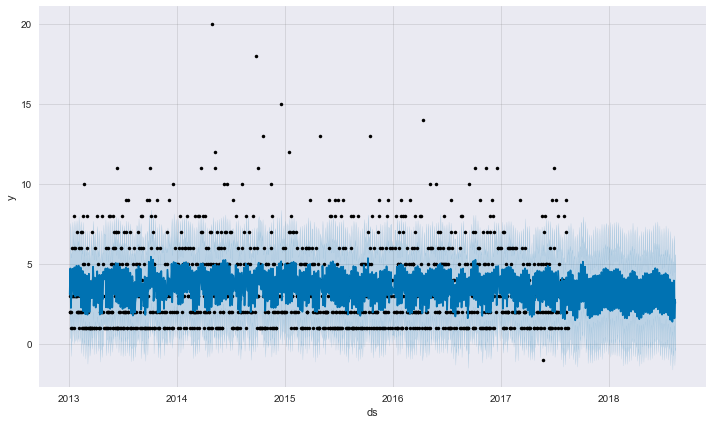

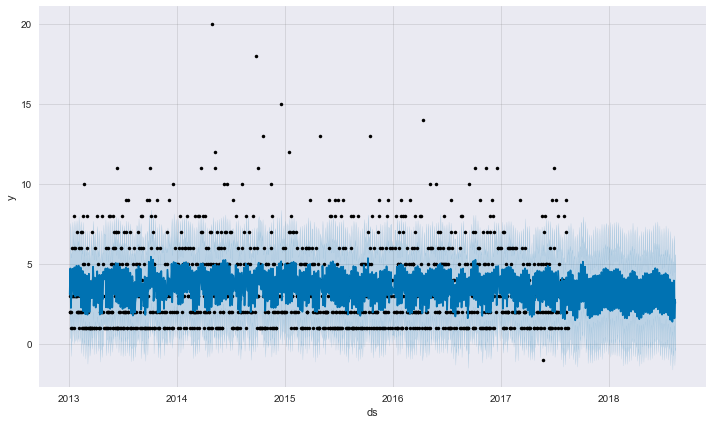

In [13]:
m.plot(forecast)

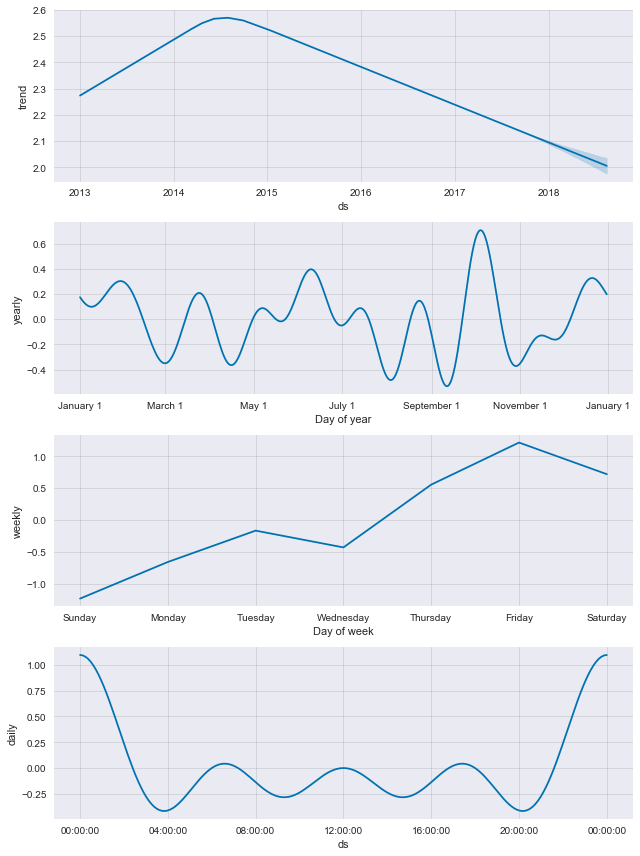

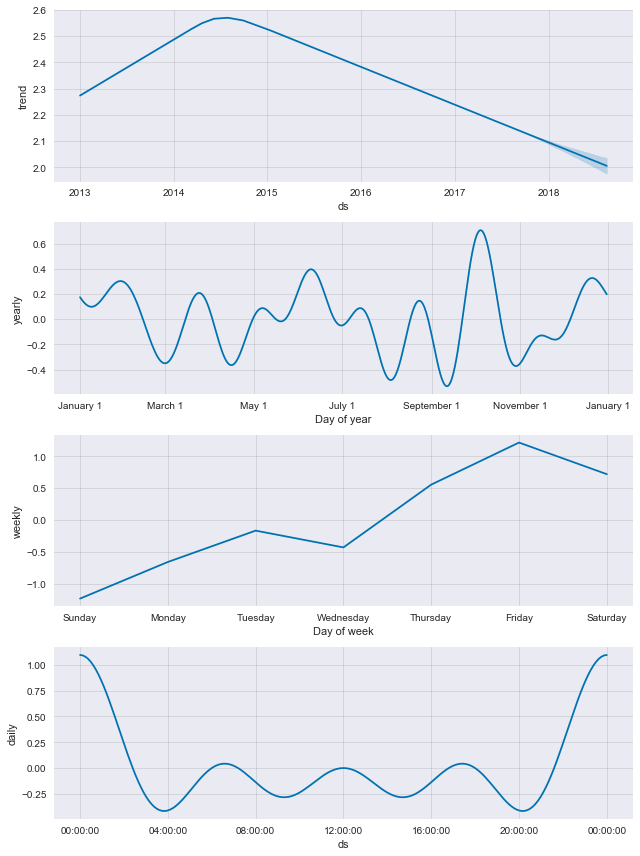

In [14]:
m.plot_components(forecast)

## Part III: feature engineering and modelling

In [5]:
import  pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV  

C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Daniel\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
data=pd.read_csv("store_1.csv")
stores=pd.read_csv("stores.csv")
holidays=pd.read_csv("holidays_events.csv")

# merge the holidays information to the dataset
data=pd.merge(data,stores,on="store_nbr")
holidays=holidays[['date','locale_name']]
df=pd.merge(data,holidays,how='left',left_on=['date','city'],right_on=['date','locale_name'])
df['holidays']=np.where(df['locale_name'].isnull(),0,1)

# extract the days from date column, and this will create a new feature, days_from
hard_date = pd.to_datetime('20130101',format='%Y%m%d')
df['days_from'] = pd.to_datetime(df['date'])-hard_date
df['days_from']=df['days_from'].dt.days

# year is converted the years since 2013; and this will also create a new feature
df['year']=df['year']-2013

# remove the columns which are not features for training
df=df.drop(['Unnamed: 0','id','locale_name','store_nbr'],axis=1)

# create the oil price feature
oilprice=pd.read_csv("oil.csv")
df['date']=pd.to_datetime(df['date'])
oilprice.dropna(inplace=True)
oilprice['date']=pd.to_datetime(oilprice['date'])
df=pd.merge(df,oilprice,how='left',left_on='date',right_on='date')
df.dcoilwtico.fillna(method='ffill',inplace=True)

# a magtitude 7.8 earthquake struck Ecuador on April 16,2016. Remove the data of a month from April 16,2016
df=df[(df['date']<'2016-04-16') | (df['date']>'2016-05-16')]

# drop some features with zero variance or near-zero variance
df=df.drop(['date','city','state','type','cluster'],axis=1)

In [7]:
# choose one items for trainning
df=df[df['item_nbr']==103665]
df.month=df.month.astype('category')
df.dayofweek=df.dayofweek.astype('category')
Categories=df[['month','dayofweek']]
dummies=pd.get_dummies(Categories,drop_first=True)
df=df.drop(['item_nbr','month','dayofweek'],axis=1)
df=pd.concat([df,dummies],axis=1)
targets=df.unit_sales
features=df.drop('unit_sales',axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.1, random_state=42)

In [8]:
# Gradient Boost Algorithm
params = {'max_depth':3,
'min_child_weight':10,
'learning_rate':0.3,
'subsample':0.5,
'colsample_bytree':0.6,
'obj':'reg:linear',
'n_estimators':1000,
'eta':0.3}

dtrain=xgb.DMatrix(X_train.values,
                     y_train.values,
                     feature_names=X_train.columns.values)
clf=xgb.train(params, dtrain)
dtest=xgb.DMatrix(X_test.values,
                     y_test.values,
                     feature_names=X_test.columns.values)
predicted_xgb=np.around(clf.predict(dtest))

# Random forest Regression
model=RandomForestRegressor(max_depth=2, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
predicted_rf=np.around(model.predict(X_test))

# Support vector Machine
clf = SVR(C=1.0, epsilon=0.2)
clf.fit(X_train,y_train)
predicted_svm=np.around(clf.predict(X_test))

In [9]:
# compare these three models with the criterion of  square errors
actual=y_test.values

error_svm=predicted_svm-actual
np.sum(error_svm**2)

error_rf=predicted_rf-actual
np.sum(error_rf**2)

# the results shows the xgb has the best performance
error_xgb=predicted_xgb-actual
np.sum(error_xgb**2)

762.0